### EDA
We are given a huge amount of data for customers' orders, locations of a restaurants. Let us see what insights we might from it

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
#import geopandas as gpd
import folium
from folium.plugins import HeatMap
import re

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 5);
sns.set_style('whitegrid')

First, we are given some varibale explanations.

In [2]:
with open('./input/restaurant-recommendation-challenge/VariableDefinitions.txt') as f:
    print(f.read())

ï»¿Train Customers


Information on the customers in the training set. 


'akeed_customer_id': Unique customer ID, used in train_locations and train_orders
'gender': Customer gender
'dob': Birth Year (if entered)
'status' and 'verified': Account status
'language': Chosen language
'Created_at' and 'updated_at': dates when account was created/updated


Train Locations


Each customer orders from one or more locations. Each is assigned a location number. 
'customer_id': The unique customer ID 
'location_number': Location number (most customers have one or two)
'location_type': Home, Work, Other or NA
'Latitude' and 'longitude': Not true latitude and longitude - locations have been masked, but nearby locations remain nearby in the new reference frame and can thus be used for clustering. However, not all locations are useful due to GPS errors and missing data - you may want to treat outliers separately.


Train Orders


This is a record of all orders made by customers in the train set from 

In [3]:
chunk_size=10000
root_dir = './input/restaurant-recommendation-challenge'
train_full = pd.read_csv(os.path.join(root_dir, 'train_full.csv'))
orders = pd.read_csv(os.path.join(root_dir, 'orders.csv'))

c:\users\anban\anaconda3\envs\pytorch\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
c:\users\anban\anaconda3\envs\pytorch\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (15,16,18,19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
vendors = pd.read_csv(os.path.join(root_dir, 'vendors.csv'))

Files attached are realy vast, let's pick just a sample of those for performance and basic analysis.

In [5]:
train_full = train_full.sample(chunk_size)
orders = orders.sample(chunk_size)

In [6]:
train_full.head()

,customer_id,gender,status_x,verified_x,created_at_x,updated_at_x,location_number,location_type,latitude_x,longitude_x,...,country_id,city_id,created_at_y,updated_at_y,device_type,display_orders,location_number_obj,id_obj,CID X LOC_NUM X VENDOR,target
2295661,F8SFBID,Male,1,1,2019-03-26 00:22:26,2019-03-26 00:22:26,0,Other,0.0329,-78.6000,...,1.0,1.0,2019-05-28 13:36:00,2020-04-03 22:18:52,3,1,0,271,F8SFBID X 0 X 271,0
1891238,Y7H5ARO,Male,1,1,2019-02-04 22:29:33,2019-02-04 22:29:32,1,NaN,0.3477,0.6010,...,1.0,1.0,2019-02-23 18:55:27,2020-04-07 20:45:16,3,1,1,176,Y7H5ARO X 1 X 176,0
3472191,0X5LWPM,NaN,1,1,2019-08-12 11:04:28,2019-10-01 18:53:36,0,NaN,1.3490,-78.7500,...,1.0,1.0,2019-12-21 00:16:09,2020-04-07 15:09:12,3,1,0,841,0X5LWPM X 0 X 841,0
3711332,SPWOZIN,Male,1,1,2019-09-05 03:22:44,2019-11-16 16:09:22,0,Home,-0.2780,-78.5600,...,1.0,1.0,2019-01-06 20:42:17,2020-04-05 21:38:58,3,1,0,149,SPWOZIN X 0 X 149,0
5256793,5Z468SS,NaN,1,1,2020-01-28 22:21:52,2020-01-28 22:22:22,0,Home,0.5420,0.5337,...,1.0,1.0,2019-12-21 12:37:34,2020-04-08 03:43:30,3,1,0,845,5Z468SS X 0 X 845,0


In [7]:
train_full.keys()

Index(['customer_id', 'gender', 'status_x', 'verified_x', 'created_at_x',
       'updated_at_x', 'location_number', 'location_type', 'latitude_x',
       'longitude_x', 'id', 'authentication_id', 'latitude_y', 'longitude_y',
       'vendor_category_en', 'vendor_category_id', 'delivery_charge',
       'serving_distance', 'is_open', 'OpeningTime', 'OpeningTime2',
       'prepration_time', 'commission', 'is_akeed_delivering',
       'discount_percentage', 'status_y', 'verified_y', 'rank', 'language',
       'vendor_rating', 'sunday_from_time1', 'sunday_to_time1',
       'sunday_from_time2', 'sunday_to_time2', 'monday_from_time1',
       'monday_to_time1', 'monday_from_time2', 'monday_to_time2',
       'tuesday_from_time1', 'tuesday_to_time1', 'tuesday_from_time2',
       'tuesday_to_time2', 'wednesday_from_time1', 'wednesday_to_time1',
       'wednesday_from_time2', 'wednesday_to_time2', 'thursday_from_time1',
       'thursday_to_time1', 'thursday_from_time2', 'thursday_to_time2',
       

In [8]:
orders.head()

,akeed_order_id,customer_id,item_count,grand_total,payment_mode,promo_code,vendor_discount_amount,promo_code_discount_percentage,is_favorite,is_rated,...,driver_accepted_time,ready_for_pickup_time,picked_up_time,delivered_time,delivery_date,vendor_id,created_at,LOCATION_NUMBER,LOCATION_TYPE,CID X LOC_NUM X VENDOR
101791,337009.0,95B00Z8,1.0,3.3,1,NaN,0.0,0.0,No,Yes,...,2020-01-18 14:37:19,2020-01-18 14:43:42,2020-01-18 14:44:15,2020-01-18 14:55:24,NaN,189,2020-01-18 14:28:53,0,Other,95B00Z8 X 0 X 189
19055,150545.0,NBHQJXI,4.0,11.7,1,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,2019-07-11 05:30:00,195,2019-07-11 20:06:48,0,NaN,NBHQJXI X 0 X 195
39225,209904.0,P0RY7TO,2.0,13.3,1,NaN,0.0,NaN,No,No,...,NaN,NaN,NaN,NaN,NaN,92,2019-10-07 14:44:13,1,NaN,P0RY7TO X 1 X 92
134705,413892.0,9PJVBKB,3.0,20.4,1,NaN,0.0,0.0,No,No,...,2020-02-29 13:25:31,2020-02-29 13:40:00,2020-02-29 13:40:42,2020-02-29 14:10:43,NaN,676,2020-02-29 13:22:07,0,Work,9PJVBKB X 0 X 676
125524,389915.0,U59I5S8,2.0,20.1,2,NaN,0.0,0.0,No,No,...,2020-02-17 16:10:50,2020-02-17 16:14:28,2020-02-17 16:17:20,2020-02-17 16:18:58,NaN,113,2020-02-17 16:04:16,1,NaN,U59I5S8 X 1 X 113


In [9]:
train_full.isna().sum().sum()

96924

<AxesSubplot:>

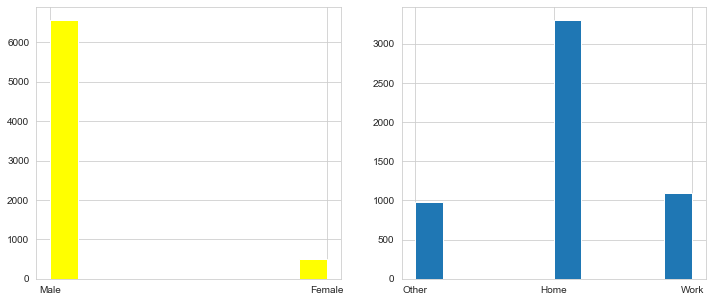

In [10]:
fig, ax = plt.subplots(1, 2)
train_full['gender'].hist(ax=ax[0], color='yellow')
train_full['location_type'].hist(ax=ax[1])

In [11]:
train_full['country_id'].value_counts()

1.0    10000
Name: country_id, dtype: int64

Hm, let us see where are our locations anyway.

In [12]:
#location Useful

locs = pd.read_csv(os.path.join(root_dir, 'train_locations.csv'))
locs.dropna(subset=['latitude'], inplace=True)
locs.dropna(subset=['longitude'], inplace=True)
print(locs.head())
print(locs['latitude'])
print(locs['longitude'])

  customer_id  location_number location_type  latitude  longitude
0     02SFNJH                0           NaN  1.682392 -78.789737
1     02SFNJH                1           NaN  1.679137   0.766823
2     02SFNJH                2           NaN -0.498648   0.661241
3     RU43CXC                0          Home  0.100853   0.438165
4     BDFBPRD                0           NaN  2.523125   0.733464
0        1.682392
1        1.679137
2       -0.498648
3        0.100853
4        2.523125
           ...   
59498   -0.788515
59499   -1.445114
59500   -0.001785
59501   -0.066291
59502   -0.067043
Name: latitude, Length: 59497, dtype: float64
0       -78.789737
1         0.766823
2         0.661241
3         0.438165
4         0.733464
           ...    
59498   -78.497721
59499     0.072558
59500     0.431695
59501   -78.583075
59502     0.648221
Name: longitude, Length: 59497, dtype: float64


In [13]:
m = folium.Map(location=[50,-85], zoom_start=2)
for i in list(locs.index)[:500]:
    folium.Marker([locs.loc[i, 'latitude'], locs.loc[i, 'longitude']]).add_to(m)
m

Needless to say there is something wrong with our location data. At least we confirmed statment from variale defenitions.
> 'Latitude' and 'longitude': Not true latitude and longitude - locations have been masked, but nearby locations remain nearby in the new reference frame and can thus be used for clustering. However, not all locations are useful due to GPS errors and missing data - you may want to treat outliers separately.

In [14]:
sorted(train_full['location_number'].unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 25]

array([[<AxesSubplot:title={'center':'status_x'}>,
        <AxesSubplot:title={'center':'status_y'}>]], dtype=object)

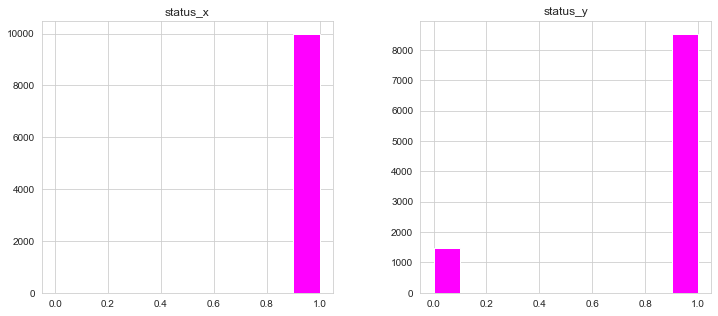

In [15]:
train_full[['status_x', 'status_y']].hist(color='magenta')   #restaurant loc with respect to center location  Discard

In [16]:
train_full['discount_percentage'].value_counts()  #Useful

0.0     9596
35.0     116
15.0     105
10.0      96
50.0      87
Name: discount_percentage, dtype: int64

In [17]:
train_full['commission'].unique()  #discard

array([ 0., nan])

In [18]:
train_full['display_orders'].value_counts()    #Useful tfidf

1    10000
Name: display_orders, dtype: int64

<AxesSubplot:>

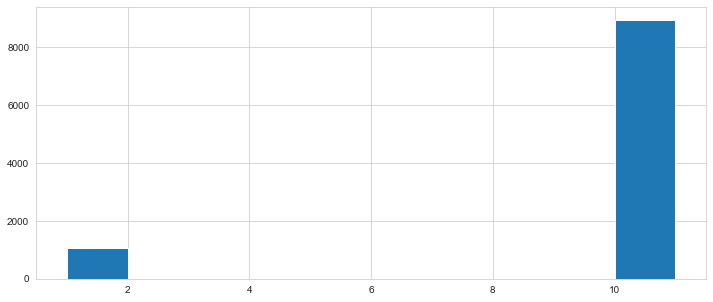

In [19]:
train_full['rank'].hist()  #Useful

<AxesSubplot:>

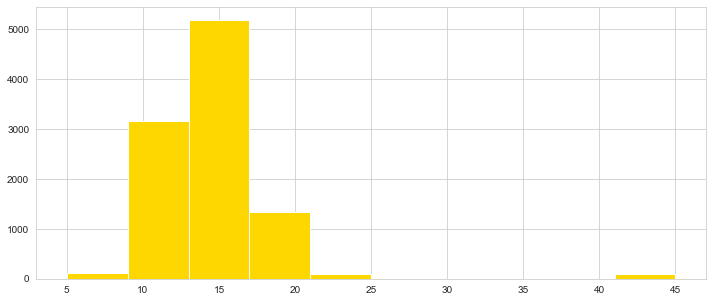

In [20]:
train_full['prepration_time'].hist(color='gold')

Well... we have many not really informative features here. Probably we can get better insights from orders and customers individually?

In [21]:
orders.head()

,akeed_order_id,customer_id,item_count,grand_total,payment_mode,promo_code,vendor_discount_amount,promo_code_discount_percentage,is_favorite,is_rated,...,driver_accepted_time,ready_for_pickup_time,picked_up_time,delivered_time,delivery_date,vendor_id,created_at,LOCATION_NUMBER,LOCATION_TYPE,CID X LOC_NUM X VENDOR
101791,337009.0,95B00Z8,1.0,3.3,1,NaN,0.0,0.0,No,Yes,...,2020-01-18 14:37:19,2020-01-18 14:43:42,2020-01-18 14:44:15,2020-01-18 14:55:24,NaN,189,2020-01-18 14:28:53,0,Other,95B00Z8 X 0 X 189
19055,150545.0,NBHQJXI,4.0,11.7,1,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,2019-07-11 05:30:00,195,2019-07-11 20:06:48,0,NaN,NBHQJXI X 0 X 195
39225,209904.0,P0RY7TO,2.0,13.3,1,NaN,0.0,NaN,No,No,...,NaN,NaN,NaN,NaN,NaN,92,2019-10-07 14:44:13,1,NaN,P0RY7TO X 1 X 92
134705,413892.0,9PJVBKB,3.0,20.4,1,NaN,0.0,0.0,No,No,...,2020-02-29 13:25:31,2020-02-29 13:40:00,2020-02-29 13:40:42,2020-02-29 14:10:43,NaN,676,2020-02-29 13:22:07,0,Work,9PJVBKB X 0 X 676
125524,389915.0,U59I5S8,2.0,20.1,2,NaN,0.0,0.0,No,No,...,2020-02-17 16:10:50,2020-02-17 16:14:28,2020-02-17 16:17:20,2020-02-17 16:18:58,NaN,113,2020-02-17 16:04:16,1,NaN,U59I5S8 X 1 X 113


In [22]:
orders.keys()

Index(['akeed_order_id', 'customer_id', 'item_count', 'grand_total',
       'payment_mode', 'promo_code', 'vendor_discount_amount',
       'promo_code_discount_percentage', 'is_favorite', 'is_rated',
       'vendor_rating', 'driver_rating', 'deliverydistance', 'preparationtime',
       'delivery_time', 'order_accepted_time', 'driver_accepted_time',
       'ready_for_pickup_time', 'picked_up_time', 'delivered_time',
       'delivery_date', 'vendor_id', 'created_at', 'LOCATION_NUMBER',
       'LOCATION_TYPE', 'CID X LOC_NUM X VENDOR'],
      dtype='object')

In [23]:
orders.describe()

,akeed_order_id,item_count,grand_total,payment_mode,vendor_discount_amount,promo_code_discount_percentage,vendor_rating,driver_rating,deliverydistance,preparationtime,vendor_id,LOCATION_NUMBER
count,9996.000000,9478.000000,10000.000000,10000.000000,10000.000000,4912.000000,3350.000000,10000.000000,10000.000000,5939.000000,10000.00000,10000.000000
mean,266054.952481,2.417810,15.330780,1.350500,0.000798,0.030537,1.972239,0.679000,4.084361,43.098165,238.26040,0.881200
std,84464.192823,1.631425,12.227045,0.765054,0.044104,0.873304,2.315024,1.669682,4.292365,6.981713,224.24768,1.265088
min,11252.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,4.00000,0.000000
25%,192879.750000,1.000000,8.200000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.000000,84.00000,0.000000
50%,268258.500000,2.000000,11.850000,1.000000,0.000000,0.000000,0.000000,0.000000,2.955000,45.000000,157.00000,1.000000
75%,335923.000000,3.000000,18.200000,1.000000,0.000000,0.000000,5.000000,0.000000,7.900000,45.000000,299.00000,1.000000
max,415462.000000,26.000000,177.400000,5.000000,4.100000,25.000000,5.000000,5.000000,14.980000,80.000000,907.00000,16.000000


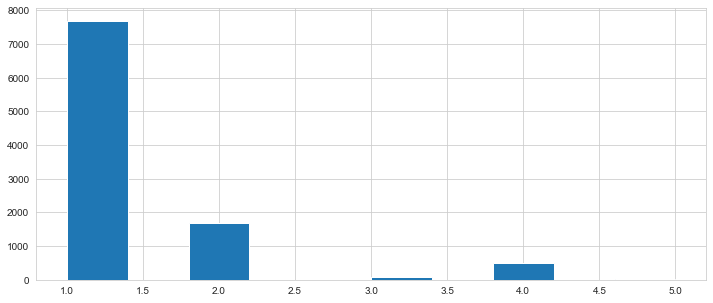

In [24]:
plt.hist(orders['payment_mode']);

<AxesSubplot:>

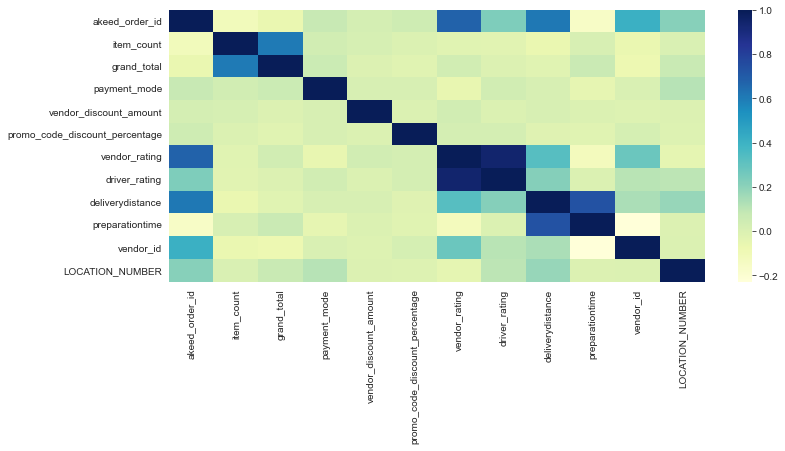

In [25]:
sns.heatmap(orders.corr(), cmap="YlGnBu")

c:\users\anban\anaconda3\envs\pytorch\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\anban\anaconda3\envs\pytorch\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='item_count', ylabel='Density'>

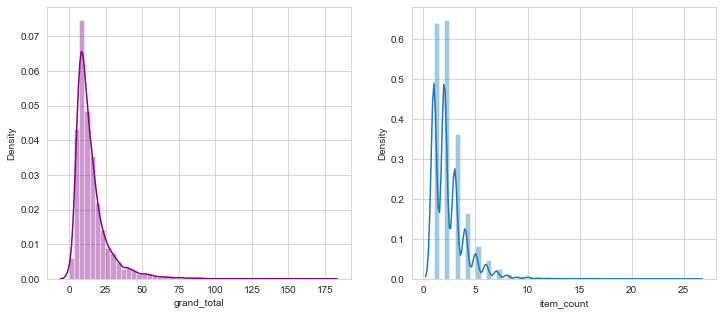

In [26]:
fig, ax = plt.subplots(1, 2)
sns.distplot(orders['grand_total'], ax=ax[0], color='purple')
sns.distplot(orders['item_count'], ax=ax[1])

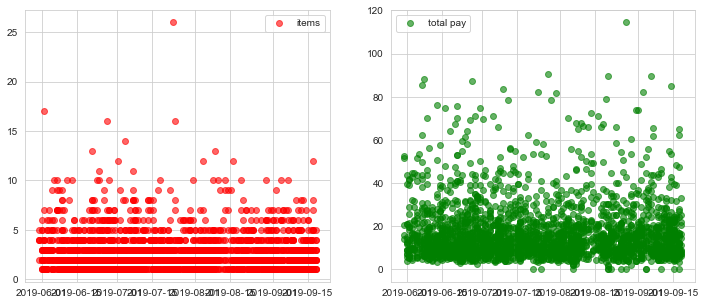

In [27]:
fig, ax = plt.subplots(1, 2)
orders.loc[:, 'delivery_date'] = pd.to_datetime(orders['delivery_date'])
ax[0].scatter(orders.set_index('delivery_date').index, orders['item_count'], 
              label='items', alpha=0.6, color='red')
ax[0].legend();
ax[1].scatter(orders.set_index('delivery_date').index, orders['grand_total'], 
              label='total pay', alpha=0.6, color='green')
ax[1].legend();

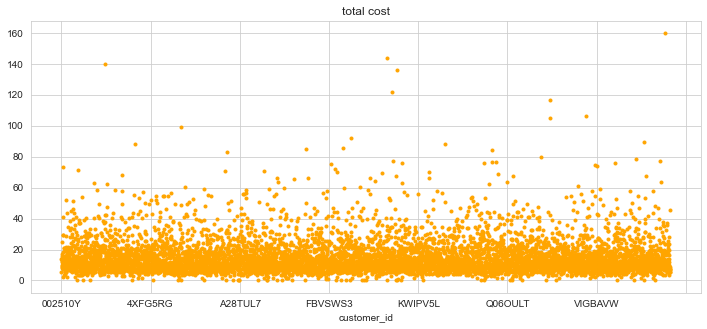

In [28]:
orders.groupby('customer_id').mean()['grand_total'].plot(marker='.', linestyle='none', color='orange')
plt.title('total cost');

Huh, we even have people how appear to pay nothing... at least according to the given data. Let's dig some more.

In [29]:
orders[orders['grand_total']==0.0]

,akeed_order_id,customer_id,item_count,grand_total,payment_mode,promo_code,vendor_discount_amount,promo_code_discount_percentage,is_favorite,is_rated,...,driver_accepted_time,ready_for_pickup_time,picked_up_time,delivered_time,delivery_date,vendor_id,created_at,LOCATION_NUMBER,LOCATION_TYPE,CID X LOC_NUM X VENDOR
9833,184550.0,OO2XWX9,2.0,0.0,1,7free850,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,2019-09-04 05:30:00,105,2019-09-04 23:30:21,0,Home,OO2XWX9 X 0 X 105
56296,246121.0,J4MG3GW,3.0,0.0,5,5d8C8F9,0.0,NaN,No,No,...,NaN,2019-11-02 17:13:41,2019-11-02 21:43:37,2019-11-02 21:56:50,NaT,386,2019-11-02 21:08:46,1,Home,J4MG3GW X 1 X 386
50014,233281.0,JJJWO2P,4.0,0.0,5,hiyam10,0.0,NaN,No,No,...,NaN,2019-10-23 15:58:47,2019-10-23 20:09:08,2019-10-23 21:06:31,NaT,289,2019-10-23 19:49:28,1,Work,JJJWO2P X 1 X 289
67914,267705.0,9V23AHC,3.0,0.0,5,5AA345,0.0,NaN,No,No,...,NaN,2019-11-19 21:51:40,2019-11-20 02:02:11,2019-11-20 02:10:48,NaT,28,2019-11-20 01:35:24,0,NaN,9V23AHC X 0 X 28
59732,252812.0,GO8UZ7F,2.0,0.0,5,freeburger,0.0,NaN,No,No,...,NaN,2019-11-07 13:20:17,2019-11-07 17:46:43,2019-11-07 18:01:27,NaT,43,2019-11-07 17:18:23,2,Home,GO8UZ7F X 2 X 43
68150,268219.0,DYW27Z7,3.0,0.0,5,5AB3CE,0.0,NaN,No,No,...,NaN,2019-11-20 12:28:19,2019-11-20 16:30:45,2019-11-20 16:37:45,NaT,79,2019-11-20 16:19:31,0,Work,DYW27Z7 X 0 X 79
53298,239956.0,FYTKIIM,4.0,0.0,5,Akeed239798,0.0,NaN,No,No,...,NaN,2019-10-28 17:23:31,2019-10-28 21:35:53,2019-10-28 22:09:36,NaT,79,2019-10-28 21:07:39,1,NaN,FYTKIIM X 1 X 79
49251,231769.0,HJEX50F,3.0,0.0,5,CD533E6,0.0,NaN,No,No,...,NaN,2019-10-22 11:43:30,2019-10-22 15:44:39,2019-10-22 15:55:06,NaT,55,2019-10-22 15:17:26,0,Home,HJEX50F X 0 X 55
71495,274701.0,XSIUCY8,2.0,0.0,5,5A8C52,0.0,NaN,No,No,...,NaN,2019-11-25 18:23:15,2019-11-25 22:29:30,2019-11-25 22:41:32,NaT,84,2019-11-25 22:02:47,0,Home,XSIUCY8 X 0 X 84
6995,177804.0,QB35ZMQ,2.0,0.0,1,7akeed3801B,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,2019-08-25 05:30:00,294,2019-08-26 02:46:42,0,Work,QB35ZMQ X 0 X 294


In [30]:
orders[orders['grand_total']==0.0]['promo_code'].isna().sum(), orders[orders['grand_total']==0.0].shape

(4, (51, 26))

Okay, so most of these people used promo code. A bit of insight we've got.

In [31]:
customers = pd.read_csv('./input/restaurant-recommendation-challenge/train_customers.csv')
customers.head()

,akeed_customer_id,gender,dob,status,verified,language,created_at,updated_at
0,TCHWPBT,Male,NaN,1,1,EN,2018-02-07 19:16:23,2018-02-07 19:16:23
1,ZGFSYCZ,Male,NaN,1,1,EN,2018-02-09 12:04:42,2018-02-09 12:04:41
2,S2ALZFL,Male,NaN,0,1,EN,2018-03-14 18:31:43,2018-03-14 18:31:42
3,952DBJQ,Male,NaN,1,1,EN,2018-03-15 19:47:07,2018-03-15 19:47:07
4,1IX6FXS,Male,NaN,1,1,EN,2018-03-15 19:57:01,2018-03-15 19:57:01


In [32]:
customers['akeed_customer_id'].nunique(), customers.shape[0]

(34523, 34674)

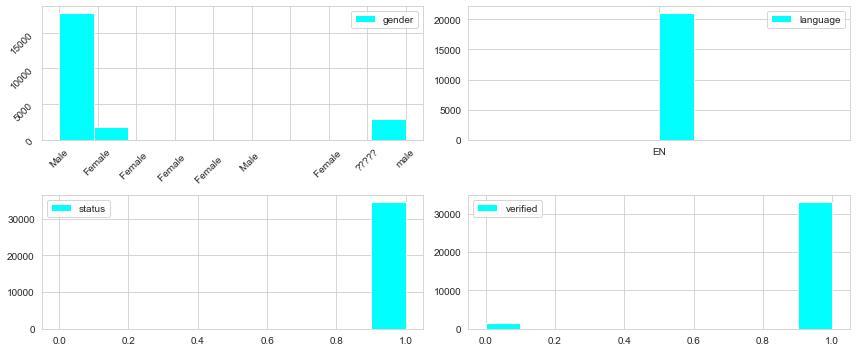

In [33]:
dists = ['gender', 'language', 'status', 'verified']
d=0
fig, ax = plt.subplots(2, 2)
for i in range(2):
    for j in range(2):
        customers[dists[d]].dropna().hist(ax=ax[i][j], label=dists[d], color='aqua')
        if dists[d] == 'gender':
            ax[i][j].tick_params(rotation=45)
        ax[i][j].legend();
        plt.tight_layout();
        d+=1

Ouch, there is some mess going on in the gender column.

<AxesSubplot:>

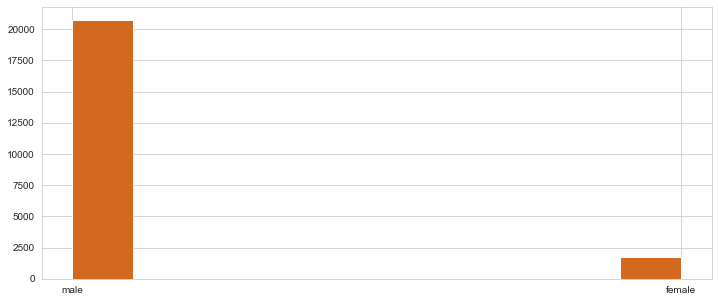

In [34]:
def clean_string(string):
    string = str(string)
    if '?' in string or string=='nan' or string.strip(' ')=='':
        return np.nan
    string = string.strip(' ').lower()
    return string

customers.loc[:, 'gender'] = customers['gender'].apply(clean_string)
customers['gender'].hist(color='chocolate')

In [35]:
def calc_age(year):
    if len(str(year))==2:
        if str(year).startswith('0'):
            year = '20'+str(year)
        else:
            year = '19'+str(year)
        year = int(year)
    if year is None:
        return np.nan
    return 2020-year

customers.loc[:, 'age'] = customers['dob'].apply(calc_age)
customers[customers['age']<16]

,akeed_customer_id,gender,dob,status,verified,language,created_at,updated_at,age
29,X282CGD,male,2018.0,1,1,EN,2018-05-06 00:29:46,2018-05-06 00:29:46,2.0
51,NL77W34,male,2018.0,1,1,EN,2018-05-11 23:09:38,2018-05-11 23:09:37,2.0
87,X02L5G7,male,2019.0,1,1,EN,2018-05-13 17:35:17,2018-05-13 17:35:17,1.0
101,3JH0AKZ,female,2018.0,1,1,EN,2018-05-15 18:09:28,2018-05-15 18:09:28,2.0
170,7M90ED1,female,2019.0,1,1,EN,2018-05-24 13:21:41,2018-05-24 13:21:40,1.0
...,...,...,...,...,...,...,...,...,...
33790,GTT1TQH,female,2020.0,1,1,NaN,2020-02-25 01:01:31,2020-02-25 01:03:54,0.0
33801,07294KB,female,2006.0,1,1,NaN,2020-02-25 02:53:36,2020-02-25 02:55:48,14.0
33891,6VXKXXH,male,2020.0,1,1,NaN,2020-02-25 23:06:03,2020-02-25 23:15:25,0.0
34317,TPYN5DV,male,2020.0,1,1,NaN,2020-02-29 15:54:07,2020-03-04 15:20:23,0.0


Well... customers as young as 1 y.o. looks truely suspicious, not too mention the accounts of such customers seems to be created the same year or even earlier than they were born... That's funny but with high confidence we can tell these are mistaken records.

<AxesSubplot:>

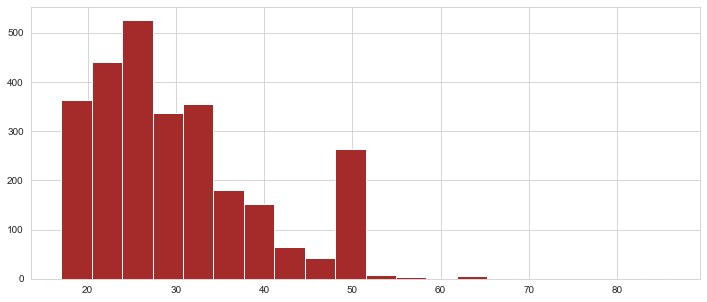

In [36]:
ages = customers[customers['age']>16]
ages = ages[ages['age']<110]
ages['age'].dropna().hist(bins=20, label='customers by age', color='brown')

That will conclude our quick look at data given. Clearly we need somewhat more effective tools to deal with high volume of data. That is what we will be doing in the <a href='https://www.kaggle.com/erelin6613/pyspark-alternating-least-squares-in-action?scriptVersionId=39511328'>next notebook</a>.

<AxesSubplot:>

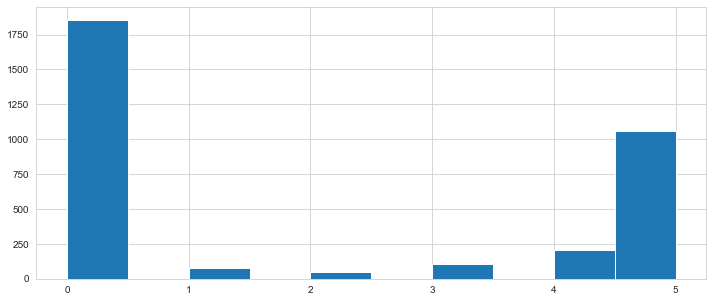

In [37]:
orders['vendor_rating'].hist()

In [38]:
orders['delivery_time'].value_counts()

2019-06-29 20:05:00    2
0000-00-00 00:00:00    2
2020-02-04 21:30:00    2
2020-02-05 11:40:00    2
2020-02-06 12:16:00    1
                      ..
2020-02-16 13:05:00    1
2019-11-12 20:44:00    1
2020-02-15 00:20:00    1
2019-08-27 22:30:00    1
2019-06-03 01:58:00    1
Name: delivery_time, Length: 366, dtype: int64

In [39]:
orders.keys()

Index(['akeed_order_id', 'customer_id', 'item_count', 'grand_total',
       'payment_mode', 'promo_code', 'vendor_discount_amount',
       'promo_code_discount_percentage', 'is_favorite', 'is_rated',
       'vendor_rating', 'driver_rating', 'deliverydistance', 'preparationtime',
       'delivery_time', 'order_accepted_time', 'driver_accepted_time',
       'ready_for_pickup_time', 'picked_up_time', 'delivered_time',
       'delivery_date', 'vendor_id', 'created_at', 'LOCATION_NUMBER',
       'LOCATION_TYPE', 'CID X LOC_NUM X VENDOR'],
      dtype='object')

In [40]:
key_to_remove_from_orders = ['akeed_order_id','promo_code', 'vendor_discount_amount','payment_mode','driver_rating','order_accepted_time','ready_for_pickup_time', 'picked_up_time', 'created_at','CID X LOC_NUM X VENDOR','delivery_date']

orders_filtered = orders.drop(key_to_remove_from_orders, axis=1)

In [41]:
orders_filtered.head()

,customer_id,item_count,grand_total,promo_code_discount_percentage,is_favorite,is_rated,vendor_rating,deliverydistance,preparationtime,delivery_time,driver_accepted_time,delivered_time,vendor_id,LOCATION_NUMBER,LOCATION_TYPE
101791,95B00Z8,1.0,3.3,0.0,No,Yes,1.0,10.78,40.0,NaN,2020-01-18 14:37:19,2020-01-18 14:55:24,189,0,Other
19055,NBHQJXI,4.0,11.7,NaN,NaN,No,NaN,0.00,NaN,NaN,NaN,NaN,195,0,NaN
39225,P0RY7TO,2.0,13.3,NaN,No,No,0.0,0.00,NaN,NaN,NaN,NaN,92,1,NaN
134705,9PJVBKB,3.0,20.4,0.0,No,No,NaN,13.92,40.0,NaN,2020-02-29 13:25:31,2020-02-29 14:10:43,676,0,Work
125524,U59I5S8,2.0,20.1,0.0,No,No,NaN,4.97,35.0,NaN,2020-02-17 16:10:50,2020-02-17 16:18:58,113,1,NaN


In [42]:
fill_with_Gaussian = ['item_count','grand_total','deliverydistance','preparationtime']
fill_with_zeros = ['promo_code_discount_percentage','is_favorite','is_rated']
import numpy as np 

In [43]:
for k in fill_with_Gaussian:
    col = orders[k].dropna()
    orders_filtered[k] = orders_filtered[k].fillna(np.random.normal(loc=col.mean(), scale=np.std(col)))

In [44]:
for k in fill_with_zeros:
    orders_filtered[k] = orders_filtered[k].fillna(0)

In [45]:
keys = list(orders_filtered.keys())
for k in keys:
    print(k)
    print(orders_filtered[k].value_counts(dropna=False))

customer_id
XW90EAP    26
VDEJEMP    14
P0RY7TO    10
BUIAFFT    10
JHLR9GG     9
           ..
3B48ZSD     1
DR3AT8I     1
7GOR5NJ     1
2QRJC10     1
NFT33LN     1
Name: customer_id, Length: 6824, dtype: int64
item_count
2.000000     3069
1.000000     3038
3.000000     1712
4.000000      786
1.603823      522
5.000000      393
6.000000      227
7.000000      119
8.000000       56
10.000000      25
9.000000       25
11.000000       9
12.000000       7
13.000000       3
16.000000       3
14.000000       2
17.000000       1
21.000000       1
15.000000       1
26.000000       1
Name: item_count, dtype: int64
grand_total
9.5     230
7.6     197
8.2     189
8.4     188
7.9     187
       ... 
37.4      1
82.8      1
2.1       1
50.7      1
45.0      1
Name: grand_total, Length: 576, dtype: int64
promo_code_discount_percentage
0.0     9994
25.0       6
Name: promo_code_discount_percentage, dtype: int64
is_favorite
No     7328
0      2533
Yes     139
Name: is_favorite, dtype: int64
is_rated


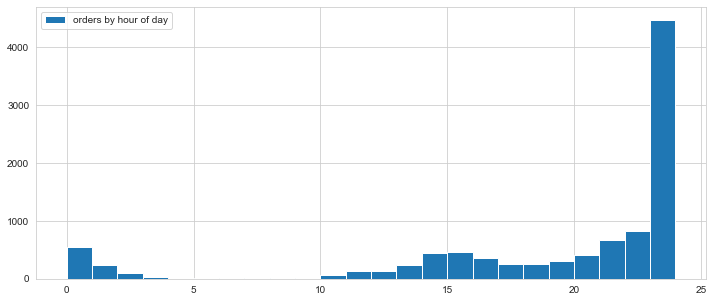

In [46]:
orders_filtered.loc[:, 'delivered_time'] = pd.to_datetime(orders_filtered['delivered_time'], errors='coerce')
orders_filtered['delivery_time'] = 24
X1 = []
X2 = []
Y = []
for i in range(0, 24):
    df = orders_filtered[orders_filtered['delivered_time'].dt.hour==i]
    #print(i,len(df))
    orders_filtered.loc[df.index, 'delivery_time'] = i
    Y.extend(orders_filtered.loc[df.index, 'delivery_time'].values)
    X1.extend(orders_filtered.loc[df.index, 'item_count'].values)
    X2.extend(orders_filtered.loc[df.index, 'grand_total'].values)

orders_filtered['delivery_time'].hist(bins=24, label='orders by hour of day')
plt.legend();

In [47]:
X = np.asarray([X2]).T
print(X.shape)


Y = np.asarray(Y)
print(Y.shape)

(6389, 1)
(6389,)


In [48]:
orders_filtered['delivery_time'].value_counts(dropna=False)

24    3611
23     864
22     819
21     664
0      548
15     463
14     441
20     415
16     357
19     309
17     252
18     252
13     246
1      230
12     129
11     128
2       97
10      65
3       35
9       16
8       16
4       12
5       12
6       12
7        7
Name: delivery_time, dtype: int64

In [49]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(X,Y)

KNeighborsClassifier(n_neighbors=50)

In [50]:
X1 = []
X2 = []
df = orders_filtered[orders_filtered['delivered_time'].dt.hour==23]
X1.extend(orders_filtered.loc[df.index, 'item_count'].values)
X2.extend(orders_filtered.loc[df.index, 'grand_total'].values)
X_ = np.asarray([X2]).T

In [51]:
pred = knn.predict(X_)
print(pred)

[22 23  0 15 21 23 22 15 14 21 22 22 21 22 22 23 23 17 21 22 22 21 22 15
 21 23 22 21  0 14 22 23 22 23 23 21 21  0 21 23 22 22  0 16 22  0 22 22
 23  0 23  0 22 22 21 23 22 22 21  0 21 22 22 22 21  0 20 23 23 22 23 21
 21 23 17 19 22 23 17 22 21 22 21 22 21 21 21 22 23 22 22 22 23 15 22 23
  0 22 21  0  0 23 23 21 23 22 21 14 21 23 22 22 21 22 21 22 23 21 23 22
 22 23 22 22 23 23 22 21 21 23 23 23 23 23 21 22 22  0 21 23 22 22 14 23
  0 22 23  0 21  0  0 21  0  0  0 22 21 22 15 21 23 22  0  0 23 22 23 23
  0 23 16 22 15 21 21 21 23 21 22 22 21 22 21 21  0 23 20 21 22  0 22 21
 19 23 21 23 23 23 23 20 22 23 21  0 17  0 16 21  0 22  0  0 22 22 22 15
 14 23 21 22  0 23 21 22 23 23  0 21 21 20 23 14 22  0 23 23 23 23 23 15
 21 23 23 21 22 22 21 23 23 23 23 22 21 23  0 22 22  0 23 22 23 14 23 23
  0 23 22 23 22 21  0 21  0  0 14 14 21 21 22 23 20 22 22 21 21 22 23 23
 22  0 23  0 23 21 16 22 22 22 23 22 21 16 23 22 22 23 16 14 23 23 22 23
 22 23 23 22 22 21 22 22 21 23 22 22 14 23 17 22 23

In [52]:
#Use KNN to fill delivery_hour

df = orders_filtered[orders_filtered['delivery_time']==24]
#orders_filtered.loc[df.index, 'delivery_hour'] = i
X_forcast = np.asarray([df['grand_total'].values]).T
print(X_forcast.shape)
pred = knn.predict(X_forcast)
print(pred.shape)
orders_filtered.loc[df.index,'delivery_time']=pred

(3611, 1)
(3611,)


In [53]:
orders_filtered['delivery_time'].value_counts()

22    2051
23    1551
21    1406
0      920
15     636
14     629
20     499
16     427
19     316
17     295
18     253
13     246
1      242
12     129
11     128
2       97
10      65
3       35
9       16
8       16
5       12
4       12
6       12
7        7
Name: delivery_time, dtype: int64

In [54]:
orders_filtered.keys()

Index(['customer_id', 'item_count', 'grand_total',
       'promo_code_discount_percentage', 'is_favorite', 'is_rated',
       'vendor_rating', 'deliverydistance', 'preparationtime', 'delivery_time',
       'driver_accepted_time', 'delivered_time', 'vendor_id',
       'LOCATION_NUMBER', 'LOCATION_TYPE'],
      dtype='object')

In [55]:
key_to_remove = ['driver_accepted_time', 'delivered_time']

orders_filtered = orders_filtered.drop(key_to_remove, axis=1)

In [56]:
orders_filtered

,customer_id,item_count,grand_total,promo_code_discount_percentage,is_favorite,is_rated,vendor_rating,deliverydistance,preparationtime,delivery_time,vendor_id,LOCATION_NUMBER,LOCATION_TYPE
101791,95B00Z8,1.0,3.3,0.0,No,Yes,1.0,10.78,40.000000,14,189,0,Other
19055,NBHQJXI,4.0,11.7,0.0,0,No,NaN,0.00,42.307479,22,195,0,NaN
39225,P0RY7TO,2.0,13.3,0.0,No,No,0.0,0.00,42.307479,22,92,1,NaN
134705,9PJVBKB,3.0,20.4,0.0,No,No,NaN,13.92,40.000000,14,676,0,Work
125524,U59I5S8,2.0,20.1,0.0,No,No,NaN,4.97,35.000000,16,113,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25452,EVLNX9L,2.0,13.9,0.0,0,No,NaN,0.00,42.307479,22,106,0,NaN
59602,4911852,3.0,13.9,0.0,No,No,0.0,5.82,45.000000,14,86,1,Home
100313,HCEQCH5,3.0,18.5,0.0,No,No,NaN,2.41,35.000000,13,843,0,Home
93011,21XTYX5,2.0,13.9,0.0,No,Yes,5.0,5.40,50.000000,23,681,0,Work


In [57]:
orders_filtered['is_favorite'].value_counts(dropna=False)

No     7328
0      2533
Yes     139
Name: is_favorite, dtype: int64

In [58]:
orders_filtered['is_rated'].value_counts(dropna=False)

No     8501
Yes    1499
Name: is_rated, dtype: int64

In [59]:
orders_filtered['is_rated'] = orders_filtered['is_rated'].fillna(0)
orders_filtered['is_favorite'] = orders_filtered['is_favorite'].fillna(0)

In [60]:
orders_filtered['is_rated'].value_counts(dropna=False)

No     8501
Yes    1499
Name: is_rated, dtype: int64

In [61]:
orders_filtered['vendor_rating'].value_counts(dropna=False)

NaN    6650
0.0    1855
5.0    1059
4.0     204
3.0     108
1.0      76
2.0      48
Name: vendor_rating, dtype: int64

In [62]:
orders_filtered['vendor_rating']=orders_filtered['vendor_rating'].fillna(5.0)

In [63]:
orders_filtered

,customer_id,item_count,grand_total,promo_code_discount_percentage,is_favorite,is_rated,vendor_rating,deliverydistance,preparationtime,delivery_time,vendor_id,LOCATION_NUMBER,LOCATION_TYPE
101791,95B00Z8,1.0,3.3,0.0,No,Yes,1.0,10.78,40.000000,14,189,0,Other
19055,NBHQJXI,4.0,11.7,0.0,0,No,5.0,0.00,42.307479,22,195,0,NaN
39225,P0RY7TO,2.0,13.3,0.0,No,No,0.0,0.00,42.307479,22,92,1,NaN
134705,9PJVBKB,3.0,20.4,0.0,No,No,5.0,13.92,40.000000,14,676,0,Work
125524,U59I5S8,2.0,20.1,0.0,No,No,5.0,4.97,35.000000,16,113,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25452,EVLNX9L,2.0,13.9,0.0,0,No,5.0,0.00,42.307479,22,106,0,NaN
59602,4911852,3.0,13.9,0.0,No,No,0.0,5.82,45.000000,14,86,1,Home
100313,HCEQCH5,3.0,18.5,0.0,No,No,5.0,2.41,35.000000,13,843,0,Home
93011,21XTYX5,2.0,13.9,0.0,No,Yes,5.0,5.40,50.000000,23,681,0,Work


In [64]:
orders_filtered['vendor_id']

101791    189
19055     195
39225      92
134705    676
125524    113
         ... 
25452     106
59602      86
100313    843
93011     681
19333     113
Name: vendor_id, Length: 10000, dtype: int64

In [65]:
orders_filtered['customer_id']

101791    95B00Z8
19055     NBHQJXI
39225     P0RY7TO
134705    9PJVBKB
125524    U59I5S8
           ...   
25452     EVLNX9L
59602     4911852
100313    HCEQCH5
93011     21XTYX5
19333     CZCNULQ
Name: customer_id, Length: 10000, dtype: object

In [66]:
#restaurant side/;
restaurant_df = orders_filtered.copy().groupby('vendor_id')

In [67]:
orders_filtered['is_favorite']

101791    No
19055      0
39225     No
134705    No
125524    No
          ..
25452      0
59602     No
100313    No
93011     No
19333      0
Name: is_favorite, Length: 10000, dtype: object

In [68]:
restaurant_side = restaurant_df['item_count','grand_total','promo_code_discount_percentage','is_favorite','is_rated','vendor_rating','preparationtime'].mean()
restaurant_side

c:\users\anban\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,item_count,grand_total,promo_code_discount_percentage,vendor_rating,preparationtime
vendor_id,,,,,
4,2.597741,14.958667,0.000000,3.926667,42.143472
13,2.138599,18.618182,0.000000,3.781818,41.755125
20,2.603947,21.300893,0.000000,3.991071,45.741640
23,2.298883,20.766667,0.000000,4.275362,43.411257
28,3.054995,13.302564,0.000000,3.700855,41.199801
...,...,...,...,...,...
849,1.964706,11.634118,0.294118,4.870588,36.470588
855,2.086207,11.796552,0.000000,4.862069,36.074267
856,2.389831,12.676271,0.423729,4.762712,36.779661


In [69]:
def get_positive_freq(x):
    s = x.value_counts()
    if len(s)>1:
        return s.values[1]
    else:
        return 0
    
def get_positive_percentage(x):
    s = x.value_counts()
    if len(s)>1:
        return s.values[1]/(s.values[1]+s.values[0])
    else:
        return 0

In [70]:
rate = restaurant_df['is_favorite','is_rated'].agg(get_positive_freq)
rate

c:\users\anban\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,is_favorite,is_rated
vendor_id,,
4,56,17
13,19,4
20,35,17
23,25,8
28,17,21
...,...,...
849,3,22
855,0,11
856,0,16


In [71]:
rate2 = restaurant_df['is_favorite','is_rated'].agg(get_positive_percentage)
rate2

c:\users\anban\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,is_favorite,is_rated
vendor_id,,
4,0.378378,0.113333
13,0.345455,0.072727
20,0.318182,0.151786
23,0.362319,0.115942
28,0.147826,0.179487
...,...,...
849,0.035294,0.258824
855,0.000000,0.189655
856,0.000000,0.271186


In [72]:
restaurant_side['is_favorite']=rate['is_favorite']
restaurant_side['is_rated']=rate['is_rated']
restaurant_side['is_favorite_percentage']=rate2['is_favorite']
restaurant_side['is_rated_percentage']=rate2['is_rated']

In [73]:
restaurant_side

,item_count,grand_total,promo_code_discount_percentage,vendor_rating,preparationtime,is_favorite,is_rated,is_favorite_percentage,is_rated_percentage
vendor_id,,,,,,,,,
4,2.597741,14.958667,0.000000,3.926667,42.143472,56,17,0.378378,0.113333
13,2.138599,18.618182,0.000000,3.781818,41.755125,19,4,0.345455,0.072727
20,2.603947,21.300893,0.000000,3.991071,45.741640,35,17,0.318182,0.151786
23,2.298883,20.766667,0.000000,4.275362,43.411257,25,8,0.362319,0.115942
28,3.054995,13.302564,0.000000,3.700855,41.199801,17,21,0.147826,0.179487
...,...,...,...,...,...,...,...,...,...
849,1.964706,11.634118,0.294118,4.870588,36.470588,3,22,0.035294,0.258824
855,2.086207,11.796552,0.000000,4.862069,36.074267,0,11,0.000000,0.189655
856,2.389831,12.676271,0.423729,4.762712,36.779661,0,16,0.000000,0.271186


In [74]:
vendors

,id,authentication_id,latitude,longitude,vendor_category_en,vendor_category_id,delivery_charge,serving_distance,is_open,OpeningTime,...,open_close_flags,vendor_tag,vendor_tag_name,one_click_vendor,country_id,city_id,created_at,updated_at,device_type,display_orders
0,4,118597.0,-0.588596,0.754434,Restaurants,2.0,0.0,6.0,1.0,11:00AM-11:30PM,...,1.0,"2,4,5,8,91,22,12,24,16,23","Arabic,Breakfast,Burgers,Desserts,Free Deliver...",Y,1.0,1.0,2018-01-30 14:42:04,2020-04-07 15:12:43,3,1
1,13,118608.0,-0.471654,0.744470,Restaurants,2.0,0.7,5.0,1.0,08:30AM-10:30PM,...,1.0,"4,41,51,34,27,15,24,16,28","Breakfast,Cakes,Crepes,Italian,Pasta,Pizzas,Sa...",Y,1.0,1.0,2018-05-03 12:32:06,2020-04-05 20:46:03,3,1
2,20,118616.0,-0.407527,0.643681,Restaurants,2.0,0.0,8.0,1.0,08:00AM-10:45PM,...,1.0,"4,8,91,10","Breakfast,Desserts,Free Delivery,Indian",Y,1.0,1.0,2018-05-04 22:28:22,2020-04-07 16:35:55,3,1
3,23,118619.0,-0.585385,0.753811,Restaurants,2.0,0.0,5.0,1.0,10:59AM-10:30PM,...,1.0,"5,8,30,24","Burgers,Desserts,Fries,Salads",Y,1.0,1.0,2018-05-06 19:20:48,2020-04-02 00:56:17,3,1
4,28,118624.0,0.480602,0.552850,Restaurants,2.0,0.7,15.0,1.0,11:00AM-11:45PM,...,1.0,5,Burgers,Y,1.0,1.0,2018-05-17 22:12:38,2020-04-05 15:57:41,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,849,130455.0,-1.588060,-0.066441,Restaurants,2.0,0.0,10.0,1.0,NaN,...,1.0,"1,4,5,6,8,91,30,43,48,24","American,Breakfast,Burgers,Cafe,Desserts,Free ...",Y,1.0,1.0,2019-12-21 12:47:39,2020-04-07 20:01:33,3,1
96,855,130463.0,2.145206,0.745025,Restaurants,2.0,0.0,8.0,1.0,NaN,...,1.0,"1,5,8,91,30,48,24","American,Burgers,Desserts,Free Delivery,Fries,...",Y,1.0,1.0,2019-12-21 13:02:32,2020-04-07 01:50:41,3,1
97,856,130464.0,0.251469,0.483632,Restaurants,2.0,0.0,7.0,1.0,NaN,...,1.0,"1,4,5,6,8,91,30,43,48,24","American,Breakfast,Burgers,Cafe,Desserts,Free ...",Y,1.0,1.0,2019-12-21 13:04:34,2020-04-06 23:53:16,3,1
98,858,130468.0,0.019817,0.587087,Restaurants,2.0,0.0,3.0,1.0,NaN,...,1.0,"1,4,5,6,8,91,30,43,48,24","American,Breakfast,Burgers,Cafe,Desserts,Free ...",Y,1.0,1.0,2019-12-21 13:12:09,2020-04-07 14:26:08,3,1


In [75]:
vendors.keys()

Index(['id', 'authentication_id', 'latitude', 'longitude',
       'vendor_category_en', 'vendor_category_id', 'delivery_charge',
       'serving_distance', 'is_open', 'OpeningTime', 'OpeningTime2',
       'prepration_time', 'commission', 'is_akeed_delivering',
       'discount_percentage', 'status', 'verified', 'rank', 'language',
       'vendor_rating', 'sunday_from_time1', 'sunday_to_time1',
       'sunday_from_time2', 'sunday_to_time2', 'monday_from_time1',
       'monday_to_time1', 'monday_from_time2', 'monday_to_time2',
       'tuesday_from_time1', 'tuesday_to_time1', 'tuesday_from_time2',
       'tuesday_to_time2', 'wednesday_from_time1', 'wednesday_to_time1',
       'wednesday_from_time2', 'wednesday_to_time2', 'thursday_from_time1',
       'thursday_to_time1', 'thursday_from_time2', 'thursday_to_time2',
       'friday_from_time1', 'friday_to_time1', 'friday_from_time2',
       'friday_to_time2', 'saturday_from_time1', 'saturday_to_time1',
       'saturday_from_time2', 'saturday

In [76]:
vendor_drop_list = ['authentication_id','vendor_category_en','sunday_from_time1', 'sunday_to_time1',
       'sunday_from_time2', 'sunday_to_time2', 'monday_from_time1',
       'monday_to_time1', 'monday_from_time2', 'monday_to_time2',
       'tuesday_from_time1', 'tuesday_to_time1', 'tuesday_from_time2',
       'tuesday_to_time2', 'wednesday_from_time1', 'wednesday_to_time1',
       'wednesday_from_time2', 'wednesday_to_time2', 'thursday_from_time1','is_akeed_delivering',
       'thursday_to_time1', 'thursday_from_time2', 'thursday_to_time2','OpeningTime','OpeningTime2',
       'friday_from_time1', 'friday_to_time1', 'friday_from_time2','open_close_flags','primary_tags','vendor_tag_name',
       'friday_to_time2', 'saturday_from_time1', 'saturday_to_time1','serving_distance','is_open','commission','language',
       'saturday_from_time2', 'saturday_to_time2','country_id','created_at', 'updated_at','device_type','display_orders']

In [77]:
vendors_filtered = vendors.drop(vendor_drop_list, axis=1)

In [78]:
vendors_filtered

,id,latitude,longitude,vendor_category_id,delivery_charge,prepration_time,discount_percentage,status,verified,rank,vendor_rating,vendor_tag,one_click_vendor,city_id
0,4,-0.588596,0.754434,2.0,0.0,15,0.0,1.0,1,11,4.4,"2,4,5,8,91,22,12,24,16,23",Y,1.0
1,13,-0.471654,0.744470,2.0,0.7,14,0.0,1.0,1,11,4.7,"4,41,51,34,27,15,24,16,28",Y,1.0
2,20,-0.407527,0.643681,2.0,0.0,19,0.0,1.0,1,1,4.5,"4,8,91,10",Y,1.0
3,23,-0.585385,0.753811,2.0,0.0,16,0.0,1.0,1,11,4.5,"5,8,30,24",Y,1.0
4,28,0.480602,0.552850,2.0,0.7,10,0.0,1.0,1,11,4.4,5,Y,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,849,-1.588060,-0.066441,2.0,0.0,10,0.0,1.0,1,1,4.1,"1,4,5,6,8,91,30,43,48,24",Y,1.0
96,855,2.145206,0.745025,2.0,0.0,10,0.0,1.0,1,1,4.2,"1,5,8,91,30,48,24",Y,1.0
97,856,0.251469,0.483632,2.0,0.0,10,0.0,1.0,1,11,4.3,"1,4,5,6,8,91,30,43,48,24",Y,1.0
98,858,0.019817,0.587087,2.0,0.0,10,0.0,1.0,1,11,4.2,"1,4,5,6,8,91,30,43,48,24",Y,1.0


In [79]:
vendors_filtered['rank'].value_counts()

11    89
1     11
Name: rank, dtype: int64

In [80]:

c = vendors_filtered['vendor_tag'].value_counts()
min_tag = 10000
max_tag = -1
for i in range(len(c)):
    l = [int(k) for k in c.index[i].split(',')]
    min_tag = min(min_tag,min(l))
    max_tag = max(max_tag,max(l))

In [81]:
vendors_filtered['vendor_tag'] = vendors_filtered['vendor_tag'].fillna('-1')

for tag_num in range(min_tag,max_tag+1):
    vendors_filtered['tag_'+str(tag_num)]=0
    for i in range(len(vendors_filtered)):
        #print(type(vendors_filtered.loc[i, 'vendor_tag']))
        if tag_num in [int(k) for k in vendors_filtered.loc[i, 'vendor_tag'].split(',')]:
            vendors_filtered.loc[i, 'tag_'+str(tag_num)]=1
vendors_filtered = vendors_filtered.drop(['vendor_tag'], axis=1)

In [82]:
vendors_filtered.loc[:,:]

,id,latitude,longitude,vendor_category_id,delivery_charge,prepration_time,discount_percentage,status,verified,rank,...,tag_82,tag_83,tag_84,tag_85,tag_86,tag_87,tag_88,tag_89,tag_90,tag_91
0,4,-0.588596,0.754434,2.0,0.0,15,0.0,1.0,1,11,...,0,0,0,0,0,0,0,0,0,1
1,13,-0.471654,0.744470,2.0,0.7,14,0.0,1.0,1,11,...,0,0,0,0,0,0,0,0,0,0
2,20,-0.407527,0.643681,2.0,0.0,19,0.0,1.0,1,1,...,0,0,0,0,0,0,0,0,0,1
3,23,-0.585385,0.753811,2.0,0.0,16,0.0,1.0,1,11,...,0,0,0,0,0,0,0,0,0,0
4,28,0.480602,0.552850,2.0,0.7,10,0.0,1.0,1,11,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,849,-1.588060,-0.066441,2.0,0.0,10,0.0,1.0,1,1,...,0,0,0,0,0,0,0,0,0,1
96,855,2.145206,0.745025,2.0,0.0,10,0.0,1.0,1,1,...,0,0,0,0,0,0,0,0,0,1
97,856,0.251469,0.483632,2.0,0.0,10,0.0,1.0,1,11,...,0,0,0,0,0,0,0,0,0,1
98,858,0.019817,0.587087,2.0,0.0,10,0.0,1.0,1,11,...,0,0,0,0,0,0,0,0,0,1


In [83]:

restaurant_side

,item_count,grand_total,promo_code_discount_percentage,vendor_rating,preparationtime,is_favorite,is_rated,is_favorite_percentage,is_rated_percentage
vendor_id,,,,,,,,,
4,2.597741,14.958667,0.000000,3.926667,42.143472,56,17,0.378378,0.113333
13,2.138599,18.618182,0.000000,3.781818,41.755125,19,4,0.345455,0.072727
20,2.603947,21.300893,0.000000,3.991071,45.741640,35,17,0.318182,0.151786
23,2.298883,20.766667,0.000000,4.275362,43.411257,25,8,0.362319,0.115942
28,3.054995,13.302564,0.000000,3.700855,41.199801,17,21,0.147826,0.179487
...,...,...,...,...,...,...,...,...,...
849,1.964706,11.634118,0.294118,4.870588,36.470588,3,22,0.035294,0.258824
855,2.086207,11.796552,0.000000,4.862069,36.074267,0,11,0.000000,0.189655
856,2.389831,12.676271,0.423729,4.762712,36.779661,0,16,0.000000,0.271186


In [84]:
restaurant_side['vendor_rating2']=restaurant_side.loc[:,'vendor_rating']
restaurant_side['favorite_by']=restaurant_side['is_favorite']
restaurant_side['rated_by']=restaurant_side['is_rated']
restaurant_side['favorite_percentage']=restaurant_side['is_favorite_percentage']
restaurant_side['rated_percentage']=restaurant_side['is_rated_percentage']
restaurant_side['average_price']=restaurant_side['vendor_rating']
restaurant_side['favorite_by']=restaurant_side['grand_total']
restaurant_side['average_item_sold']=restaurant_side['item_count']
keep = ['average_item_sold','favorite_by','average_price','rated_percentage','favorite_percentage','rated_by','favorite_by','vendor_rating2']
to_drop = [k for k in restaurant_side.keys() if k not in keep]
restaurant_side = restaurant_side.drop(to_drop,axis=1)

In [85]:
restaurant_side

,vendor_rating2,favorite_by,rated_by,favorite_percentage,rated_percentage,average_price,average_item_sold
vendor_id,,,,,,,
4,3.926667,14.958667,17,0.378378,0.113333,3.926667,2.597741
13,3.781818,18.618182,4,0.345455,0.072727,3.781818,2.138599
20,3.991071,21.300893,17,0.318182,0.151786,3.991071,2.603947
23,4.275362,20.766667,8,0.362319,0.115942,4.275362,2.298883
28,3.700855,13.302564,21,0.147826,0.179487,3.700855,3.054995
...,...,...,...,...,...,...,...
849,4.870588,11.634118,22,0.035294,0.258824,4.870588,1.964706
855,4.862069,11.796552,11,0.000000,0.189655,4.862069,2.086207
856,4.762712,12.676271,16,0.000000,0.271186,4.762712,2.389831


In [86]:
restaurant = pd.merge(restaurant_side,vendors_filtered,left_on='vendor_id', right_on='id')

In [87]:
vendor_id = restaurant['id']
restaurant = restaurant.drop(['id'],axis=1)
restaurant.insert(0,'vendor_id',vendor_id)

# Restaurant Representation

In [88]:
restaurant

,vendor_id,vendor_rating2,favorite_by,rated_by,favorite_percentage,rated_percentage,average_price,average_item_sold,latitude,longitude,...,tag_82,tag_83,tag_84,tag_85,tag_86,tag_87,tag_88,tag_89,tag_90,tag_91
0,4,3.926667,14.958667,17,0.378378,0.113333,3.926667,2.597741,-0.588596,0.754434,...,0,0,0,0,0,0,0,0,0,1
1,13,3.781818,18.618182,4,0.345455,0.072727,3.781818,2.138599,-0.471654,0.744470,...,0,0,0,0,0,0,0,0,0,0
2,20,3.991071,21.300893,17,0.318182,0.151786,3.991071,2.603947,-0.407527,0.643681,...,0,0,0,0,0,0,0,0,0,1
3,23,4.275362,20.766667,8,0.362319,0.115942,4.275362,2.298883,-0.585385,0.753811,...,0,0,0,0,0,0,0,0,0,0
4,28,3.700855,13.302564,21,0.147826,0.179487,3.700855,3.054995,0.480602,0.552850,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,849,4.870588,11.634118,22,0.035294,0.258824,4.870588,1.964706,-1.588060,-0.066441,...,0,0,0,0,0,0,0,0,0,1
96,855,4.862069,11.796552,11,0.000000,0.189655,4.862069,2.086207,2.145206,0.745025,...,0,0,0,0,0,0,0,0,0,1
97,856,4.762712,12.676271,16,0.000000,0.271186,4.762712,2.389831,0.251469,0.483632,...,0,0,0,0,0,0,0,0,0,1
98,858,4.827586,10.189655,14,0.034483,0.241379,4.827586,1.793103,0.019817,0.587087,...,0,0,0,0,0,0,0,0,0,1


In [89]:
for i in restaurant.keys():
    print(i)

vendor_id
vendor_rating2
favorite_by
rated_by
favorite_percentage
rated_percentage
average_price
average_item_sold
latitude
longitude
vendor_category_id
delivery_charge
prepration_time
discount_percentage
status
verified
rank
vendor_rating
one_click_vendor
city_id
tag_1
tag_2
tag_3
tag_4
tag_5
tag_6
tag_7
tag_8
tag_9
tag_10
tag_11
tag_12
tag_13
tag_14
tag_15
tag_16
tag_17
tag_18
tag_19
tag_20
tag_21
tag_22
tag_23
tag_24
tag_25
tag_26
tag_27
tag_28
tag_29
tag_30
tag_31
tag_32
tag_33
tag_34
tag_35
tag_36
tag_37
tag_38
tag_39
tag_40
tag_41
tag_42
tag_43
tag_44
tag_45
tag_46
tag_47
tag_48
tag_49
tag_50
tag_51
tag_52
tag_53
tag_54
tag_55
tag_56
tag_57
tag_58
tag_59
tag_60
tag_61
tag_62
tag_63
tag_64
tag_65
tag_66
tag_67
tag_68
tag_69
tag_70
tag_71
tag_72
tag_73
tag_74
tag_75
tag_76
tag_77
tag_78
tag_79
tag_80
tag_81
tag_82
tag_83
tag_84
tag_85
tag_86
tag_87
tag_88
tag_89
tag_90
tag_91


In [90]:
customers = pd.read_csv(os.path.join(root_dir, 'train_customers.csv'))

In [91]:
customers

,akeed_customer_id,gender,dob,status,verified,language,created_at,updated_at
0,TCHWPBT,Male,NaN,1,1,EN,2018-02-07 19:16:23,2018-02-07 19:16:23
1,ZGFSYCZ,Male,NaN,1,1,EN,2018-02-09 12:04:42,2018-02-09 12:04:41
2,S2ALZFL,Male,NaN,0,1,EN,2018-03-14 18:31:43,2018-03-14 18:31:42
3,952DBJQ,Male,NaN,1,1,EN,2018-03-15 19:47:07,2018-03-15 19:47:07
4,1IX6FXS,Male,NaN,1,1,EN,2018-03-15 19:57:01,2018-03-15 19:57:01
...,...,...,...,...,...,...,...,...
34669,JAI79PE,NaN,NaN,1,1,NaN,2020-03-03 13:01:13,2020-03-03 13:02:21
34670,TR75VFL,NaN,NaN,1,1,NaN,2020-03-03 13:22:35,2020-03-03 13:22:41
34671,SQMJ08H,NaN,NaN,1,1,NaN,2020-03-03 13:24:27,2020-03-03 13:24:44
34672,9LW9CHN,NaN,NaN,1,1,NaN,2020-03-03 13:24:28,2020-03-03 13:28:00


In [92]:
customers

,akeed_customer_id,gender,dob,status,verified,language,created_at,updated_at
0,TCHWPBT,Male,NaN,1,1,EN,2018-02-07 19:16:23,2018-02-07 19:16:23
1,ZGFSYCZ,Male,NaN,1,1,EN,2018-02-09 12:04:42,2018-02-09 12:04:41
2,S2ALZFL,Male,NaN,0,1,EN,2018-03-14 18:31:43,2018-03-14 18:31:42
3,952DBJQ,Male,NaN,1,1,EN,2018-03-15 19:47:07,2018-03-15 19:47:07
4,1IX6FXS,Male,NaN,1,1,EN,2018-03-15 19:57:01,2018-03-15 19:57:01
...,...,...,...,...,...,...,...,...
34669,JAI79PE,NaN,NaN,1,1,NaN,2020-03-03 13:01:13,2020-03-03 13:02:21
34670,TR75VFL,NaN,NaN,1,1,NaN,2020-03-03 13:22:35,2020-03-03 13:22:41
34671,SQMJ08H,NaN,NaN,1,1,NaN,2020-03-03 13:24:27,2020-03-03 13:24:44
34672,9LW9CHN,NaN,NaN,1,1,NaN,2020-03-03 13:24:28,2020-03-03 13:28:00


In [93]:
orders_filtered.keys()

Index(['customer_id', 'item_count', 'grand_total',
       'promo_code_discount_percentage', 'is_favorite', 'is_rated',
       'vendor_rating', 'deliverydistance', 'preparationtime', 'delivery_time',
       'vendor_id', 'LOCATION_NUMBER', 'LOCATION_TYPE'],
      dtype='object')

In [94]:
train_full

,customer_id,gender,status_x,verified_x,created_at_x,updated_at_x,location_number,location_type,latitude_x,longitude_x,...,country_id,city_id,created_at_y,updated_at_y,device_type,display_orders,location_number_obj,id_obj,CID X LOC_NUM X VENDOR,target
2295661,F8SFBID,Male,1,1,2019-03-26 00:22:26,2019-03-26 00:22:26,0,Other,0.03290,-78.60000,...,1.0,1.0,2019-05-28 13:36:00,2020-04-03 22:18:52,3,1,0,271,F8SFBID X 0 X 271,0
1891238,Y7H5ARO,Male,1,1,2019-02-04 22:29:33,2019-02-04 22:29:32,1,NaN,0.34770,0.60100,...,1.0,1.0,2019-02-23 18:55:27,2020-04-07 20:45:16,3,1,1,176,Y7H5ARO X 1 X 176,0
3472191,0X5LWPM,NaN,1,1,2019-08-12 11:04:28,2019-10-01 18:53:36,0,NaN,1.34900,-78.75000,...,1.0,1.0,2019-12-21 00:16:09,2020-04-07 15:09:12,3,1,0,841,0X5LWPM X 0 X 841,0
3711332,SPWOZIN,Male,1,1,2019-09-05 03:22:44,2019-11-16 16:09:22,0,Home,-0.27800,-78.56000,...,1.0,1.0,2019-01-06 20:42:17,2020-04-05 21:38:58,3,1,0,149,SPWOZIN X 0 X 149,0
5256793,5Z468SS,NaN,1,1,2020-01-28 22:21:52,2020-01-28 22:22:22,0,Home,0.54200,0.53370,...,1.0,1.0,2019-12-21 12:37:34,2020-04-08 03:43:30,3,1,0,845,5Z468SS X 0 X 845,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1654137,6UOCCK3,Male,1,1,2019-01-03 22:09:35,2019-01-03 22:09:34,0,NaN,-0.10315,0.12354,...,1.0,1.0,2019-01-30 18:26:39,2020-04-05 11:47:10,3,1,0,161,6UOCCK3 X 0 X 161,0
2704492,P584KU2,NaN,1,1,2019-06-02 19:49:09,2019-10-01 18:44:18,0,NaN,0.03270,0.53760,...,1.0,1.0,2019-12-21 12:31:16,2020-04-07 19:01:17,3,1,0,843,P584KU2 X 0 X 843,0
5591171,1DBPPPF,NaN,1,1,2020-02-15 14:53:26,2020-02-15 14:53:45,0,Home,0.11237,0.41650,...,1.0,1.0,2019-07-03 10:38:21,2020-04-02 12:35:56,3,1,0,304,1DBPPPF X 0 X 304,0
4042570,GDIDS3P,Male,1,1,2019-10-01 01:30:08,2019-11-16 16:51:22,1,Home,-0.14560,0.10254,...,1.0,1.0,2019-07-02 14:50:31,2020-03-31 13:23:57,3,1,1,303,GDIDS3P X 1 X 303,0


In [95]:
train_full.keys()

Index(['customer_id', 'gender', 'status_x', 'verified_x', 'created_at_x',
       'updated_at_x', 'location_number', 'location_type', 'latitude_x',
       'longitude_x', 'id', 'authentication_id', 'latitude_y', 'longitude_y',
       'vendor_category_en', 'vendor_category_id', 'delivery_charge',
       'serving_distance', 'is_open', 'OpeningTime', 'OpeningTime2',
       'prepration_time', 'commission', 'is_akeed_delivering',
       'discount_percentage', 'status_y', 'verified_y', 'rank', 'language',
       'vendor_rating', 'sunday_from_time1', 'sunday_to_time1',
       'sunday_from_time2', 'sunday_to_time2', 'monday_from_time1',
       'monday_to_time1', 'monday_from_time2', 'monday_to_time2',
       'tuesday_from_time1', 'tuesday_to_time1', 'tuesday_from_time2',
       'tuesday_to_time2', 'wednesday_from_time1', 'wednesday_to_time1',
       'wednesday_from_time2', 'wednesday_to_time2', 'thursday_from_time1',
       'thursday_to_time1', 'thursday_from_time2', 'thursday_to_time2',
       

# We should use 'latitude_x','longitude_x','city_id' to filter out restaurants that are too far. Then make recommendation based on users preferrence

In [96]:
keep = ['customer_id','gender','location_type','location_number','latitude_x','longitude_x','city_id','vendor_tag',]
to_drop = [k for k in train_full.keys() if k not in keep]
customer_basic = train_full.drop(to_drop,axis=1)

In [97]:
customer_basic

,customer_id,gender,location_number,location_type,latitude_x,longitude_x,vendor_tag,city_id
2295661,F8SFBID,Male,0,Other,0.03290,-78.60000,"1,5,48,27,16,36,28,35",1.0
1891238,Y7H5ARO,Male,1,NaN,0.34770,0.60100,"4,8,22,32,24,16,28",1.0
3472191,0X5LWPM,NaN,0,NaN,1.34900,-78.75000,"1,4,5,6,8,91,30,43,48,24",1.0
3711332,SPWOZIN,Male,0,Home,-0.27800,-78.56000,2,1.0
5256793,5Z468SS,NaN,0,Home,0.54200,0.53370,"1,4,5,6,8,91,30,43,48,24",1.0
...,...,...,...,...,...,...,...,...
1654137,6UOCCK3,Male,0,NaN,-0.10315,0.12354,"5,8,63,15",1.0
2704492,P584KU2,NaN,0,NaN,0.03270,0.53760,"1,4,5,6,8,91,30,43,48,24",1.0
5591171,1DBPPPF,NaN,0,Home,0.11237,0.41650,"1,4,5,30,16",1.0
4042570,GDIDS3P,Male,1,Home,-0.14560,0.10254,"60,38,61,16,36",1.0


In [98]:
kw = ["Male",'Female']
for i,k in enumerate(kw):
    df = customer_basic[customer_basic['gender']==k]
    customer_basic.loc[df.index,'gender']=i
df = customer_basic[customer_basic['gender'].isna()]
customer_basic.loc[df.index,'gender']=3

In [99]:
customer_basic

,customer_id,gender,location_number,location_type,latitude_x,longitude_x,vendor_tag,city_id
2295661,F8SFBID,0,0,Other,0.03290,-78.60000,"1,5,48,27,16,36,28,35",1.0
1891238,Y7H5ARO,0,1,NaN,0.34770,0.60100,"4,8,22,32,24,16,28",1.0
3472191,0X5LWPM,3,0,NaN,1.34900,-78.75000,"1,4,5,6,8,91,30,43,48,24",1.0
3711332,SPWOZIN,0,0,Home,-0.27800,-78.56000,2,1.0
5256793,5Z468SS,3,0,Home,0.54200,0.53370,"1,4,5,6,8,91,30,43,48,24",1.0
...,...,...,...,...,...,...,...,...
1654137,6UOCCK3,0,0,NaN,-0.10315,0.12354,"5,8,63,15",1.0
2704492,P584KU2,3,0,NaN,0.03270,0.53760,"1,4,5,6,8,91,30,43,48,24",1.0
5591171,1DBPPPF,3,0,Home,0.11237,0.41650,"1,4,5,30,16",1.0
4042570,GDIDS3P,0,1,Home,-0.14560,0.10254,"60,38,61,16,36",1.0


In [100]:
kw = ["Home",'Work','Other']
for i,k in enumerate(kw):
    df = customer_basic[customer_basic['location_type']==k]
    customer_basic.loc[df.index,'location_type']=i
df = customer_basic[customer_basic['location_type'].isna()]
customer_basic.loc[df.index,'location_type']=2

In [101]:
customer_basic

,customer_id,gender,location_number,location_type,latitude_x,longitude_x,vendor_tag,city_id
2295661,F8SFBID,0,0,2,0.03290,-78.60000,"1,5,48,27,16,36,28,35",1.0
1891238,Y7H5ARO,0,1,2,0.34770,0.60100,"4,8,22,32,24,16,28",1.0
3472191,0X5LWPM,3,0,2,1.34900,-78.75000,"1,4,5,6,8,91,30,43,48,24",1.0
3711332,SPWOZIN,0,0,0,-0.27800,-78.56000,2,1.0
5256793,5Z468SS,3,0,0,0.54200,0.53370,"1,4,5,6,8,91,30,43,48,24",1.0
...,...,...,...,...,...,...,...,...
1654137,6UOCCK3,0,0,2,-0.10315,0.12354,"5,8,63,15",1.0
2704492,P584KU2,3,0,2,0.03270,0.53760,"1,4,5,6,8,91,30,43,48,24",1.0
5591171,1DBPPPF,3,0,0,0.11237,0.41650,"1,4,5,30,16",1.0
4042570,GDIDS3P,0,1,0,-0.14560,0.10254,"60,38,61,16,36",1.0


In [102]:
customer_basic['location_number'].value_counts(dropna=False)

0     5933
1     2332
2      875
3      439
4      202
5       71
6       64
7       35
8       14
10      10
9        6
12       6
11       4
15       3
17       1
25       1
13       1
16       1
14       1
18       1
Name: location_number, dtype: int64

In [103]:
customer_basic['gender'] = pd.to_numeric(customer_basic['gender'])
customer_basic['location_number'] = pd.to_numeric(customer_basic['location_number'])
customer_basic['location_type'] = pd.to_numeric(customer_basic['location_type'])

In [104]:
customer_df = customer_basic.groupby(by=['customer_id'])

In [105]:
def get_customer_prefered_tags(x):
    s = x.value_counts()
    t = [0]*(max_tag-min_tag+1)
    for i in range(len(s)):
        l = [int(k) for k in s.index[i].split(',')]
        for g in l:
            t[g-min_tag]+=1
    return ','.join([str(m) for m in t])
        

In [106]:

customer_side = customer_df['vendor_tag'].agg(get_customer_prefered_tags)
customer_side

customer_id
009UFS1    1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...
00FQ1U9    1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...
00GV4J4    0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,...
00HRRAK    2,0,0,0,2,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,...
00PUAIX    0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...
                                 ...                        
ZZG19GH    0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...
ZZH6RXR    0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,...
ZZV4CF7    1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...
ZZV91QR    1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...
ZZVLIB5    0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...
Name: vendor_tag, Length: 8289, dtype: object

In [107]:
for i in range(min_tag,max_tag+1):
    customer_basic['tag_'+str(i)]=0

In [108]:
customer_side.keys()

Index(['009UFS1', '00FQ1U9', '00GV4J4', '00HRRAK', '00PUAIX', '00QC44G',
       '00R9C57', '010DVV3', '01BY7WQ', '01E7ZHU',
       ...
       'ZZ07CB3', 'ZZ0PZGU', 'ZZ10VI0', 'ZZ19MGB', 'ZZBPHU4', 'ZZG19GH',
       'ZZH6RXR', 'ZZV4CF7', 'ZZV91QR', 'ZZVLIB5'],
      dtype='object', name='customer_id', length=8289)

In [109]:
preference = {}
for k in customer_side.keys():
    preference[k]=[int(t) for t in customer_side[k].split(',')]

In [111]:
for i in range(len(customer_basic)):
    if i%500==0:
        print(i)
    id = customer_basic.iloc[i,0]
    p = preference[id]
    for j in range(len(p)):
        customer_basic.iloc[i,j+8]=p[j]

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500


In [112]:
customer_basic

,customer_id,gender,location_number,location_type,latitude_x,longitude_x,vendor_tag,city_id,tag_1,tag_2,...,tag_82,tag_83,tag_84,tag_85,tag_86,tag_87,tag_88,tag_89,tag_90,tag_91
2295661,F8SFBID,0,0,2,0.03290,-78.60000,"1,5,48,27,16,36,28,35",1.0,1,0,...,0,0,0,0,0,0,0,0,0,0
1891238,Y7H5ARO,0,1,2,0.34770,0.60100,"4,8,22,32,24,16,28",1.0,0,0,...,0,0,0,0,0,0,0,0,0,0
3472191,0X5LWPM,3,0,2,1.34900,-78.75000,"1,4,5,6,8,91,30,43,48,24",1.0,1,0,...,0,0,0,0,0,0,0,0,0,1
3711332,SPWOZIN,0,0,0,-0.27800,-78.56000,2,1.0,0,1,...,0,0,0,0,0,0,0,0,0,0
5256793,5Z468SS,3,0,0,0.54200,0.53370,"1,4,5,6,8,91,30,43,48,24",1.0,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1654137,6UOCCK3,0,0,2,-0.10315,0.12354,"5,8,63,15",1.0,1,0,...,0,0,0,0,0,0,0,0,0,0
2704492,P584KU2,3,0,2,0.03270,0.53760,"1,4,5,6,8,91,30,43,48,24",1.0,1,0,...,0,0,0,0,0,0,0,0,0,1
5591171,1DBPPPF,3,0,0,0.11237,0.41650,"1,4,5,30,16",1.0,1,0,...,0,0,0,0,0,0,0,0,0,1
4042570,GDIDS3P,0,1,0,-0.14560,0.10254,"60,38,61,16,36",1.0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [113]:
customer_basic['tag_2'].value_counts()

0    8565
1    1399
2      36
Name: tag_2, dtype: int64

In [114]:
customer_basic = customer_basic.drop(['vendor_tag'],axis=1)

In [115]:
customer_basic

,customer_id,gender,location_number,location_type,latitude_x,longitude_x,city_id,tag_1,tag_2,tag_3,...,tag_82,tag_83,tag_84,tag_85,tag_86,tag_87,tag_88,tag_89,tag_90,tag_91
2295661,F8SFBID,0,0,2,0.03290,-78.60000,1.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1891238,Y7H5ARO,0,1,2,0.34770,0.60100,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3472191,0X5LWPM,3,0,2,1.34900,-78.75000,1.0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3711332,SPWOZIN,0,0,0,-0.27800,-78.56000,1.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5256793,5Z468SS,3,0,0,0.54200,0.53370,1.0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1654137,6UOCCK3,0,0,2,-0.10315,0.12354,1.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2704492,P584KU2,3,0,2,0.03270,0.53760,1.0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
5591171,1DBPPPF,3,0,0,0.11237,0.41650,1.0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4042570,GDIDS3P,0,1,0,-0.14560,0.10254,1.0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [116]:
customer_economic = orders_filtered.groupby(by=['customer_id'])['grand_total','item_count'].mean()
customer_economic

c:\users\anban\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,grand_total,item_count
customer_id,,
002510Y,13.600000,3.000000
009UFS1,5.700000,1.000000
00HRRAK,14.700000,3.000000
00OT8JX,25.150000,2.900956
010DVV3,8.400000,1.000000
...,...,...
ZYOOK78,5.700000,1.000000
ZZG19GH,8.700000,1.000000
ZZH6RXR,7.600000,2.000000


In [117]:
customer_basic['grand_total']=np.nan
customer_basic['item_count']=np.nan

In [118]:
customer_basic

,customer_id,gender,location_number,location_type,latitude_x,longitude_x,city_id,tag_1,tag_2,tag_3,...,tag_84,tag_85,tag_86,tag_87,tag_88,tag_89,tag_90,tag_91,grand_total,item_count
2295661,F8SFBID,0,0,2,0.03290,-78.60000,1.0,1,0,0,...,0,0,0,0,0,0,0,0,NaN,NaN
1891238,Y7H5ARO,0,1,2,0.34770,0.60100,1.0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,NaN
3472191,0X5LWPM,3,0,2,1.34900,-78.75000,1.0,1,0,0,...,0,0,0,0,0,0,0,1,NaN,NaN
3711332,SPWOZIN,0,0,0,-0.27800,-78.56000,1.0,0,1,0,...,0,0,0,0,0,0,0,0,NaN,NaN
5256793,5Z468SS,3,0,0,0.54200,0.53370,1.0,1,0,0,...,0,0,0,0,0,0,0,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1654137,6UOCCK3,0,0,2,-0.10315,0.12354,1.0,1,0,0,...,0,0,0,0,0,0,0,0,NaN,NaN
2704492,P584KU2,3,0,2,0.03270,0.53760,1.0,1,0,0,...,0,0,0,0,0,0,0,1,NaN,NaN
5591171,1DBPPPF,3,0,0,0.11237,0.41650,1.0,1,0,0,...,0,0,0,0,0,0,0,1,NaN,NaN
4042570,GDIDS3P,0,1,0,-0.14560,0.10254,1.0,1,0,0,...,0,0,0,0,0,0,0,1,NaN,NaN


In [119]:
for i in range(len(customer_basic)):
    if i%500==0:
        print(i)
    id = customer_basic.iloc[i,0]
    try:
        customer_basic.iloc[i,-2]=customer_economic.loc[id,'grand_total']
        customer_basic.iloc[i,-1]=customer_economic.loc[id,'item_count']
    except Exception:
        pass

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500


In [120]:
customer_basic['grand_total']=customer_basic['grand_total'].fillna(customer_basic['grand_total'].mean())
customer_basic['item_count']=customer_basic['item_count'].fillna(customer_basic['item_count'].mean())

In [121]:
customer_basic['grand_total'].value_counts()

16.293828    7147
11.700000      37
12.200000      37
15.500000      37
9.200000       36
             ... 
18.775000       1
67.800000       1
33.850000       1
9.650000        1
0.700000        1
Name: grand_total, Length: 753, dtype: int64

# Data Format

In [122]:
customer_basic

,customer_id,gender,location_number,location_type,latitude_x,longitude_x,city_id,tag_1,tag_2,tag_3,...,tag_84,tag_85,tag_86,tag_87,tag_88,tag_89,tag_90,tag_91,grand_total,item_count
2295661,F8SFBID,0,0,2,0.03290,-78.60000,1.0,1,0,0,...,0,0,0,0,0,0,0,0,7.100000,2.00000
1891238,Y7H5ARO,0,1,2,0.34770,0.60100,1.0,0,0,0,...,0,0,0,0,0,0,0,0,16.293828,2.44188
3472191,0X5LWPM,3,0,2,1.34900,-78.75000,1.0,1,0,0,...,0,0,0,0,0,0,0,1,16.293828,2.44188
3711332,SPWOZIN,0,0,0,-0.27800,-78.56000,1.0,0,1,0,...,0,0,0,0,0,0,0,0,16.293828,2.44188
5256793,5Z468SS,3,0,0,0.54200,0.53370,1.0,1,0,0,...,0,0,0,0,0,0,0,1,16.293828,2.44188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1654137,6UOCCK3,0,0,2,-0.10315,0.12354,1.0,1,0,0,...,0,0,0,0,0,0,0,0,16.293828,2.44188
2704492,P584KU2,3,0,2,0.03270,0.53760,1.0,1,0,0,...,0,0,0,0,0,0,0,1,16.293828,2.44188
5591171,1DBPPPF,3,0,0,0.11237,0.41650,1.0,1,0,0,...,0,0,0,0,0,0,0,1,16.293828,2.44188
4042570,GDIDS3P,0,1,0,-0.14560,0.10254,1.0,1,0,0,...,0,0,0,0,0,0,0,1,21.500000,1.00000


In [123]:
restaurant

,vendor_id,vendor_rating2,favorite_by,rated_by,favorite_percentage,rated_percentage,average_price,average_item_sold,latitude,longitude,...,tag_82,tag_83,tag_84,tag_85,tag_86,tag_87,tag_88,tag_89,tag_90,tag_91
0,4,3.926667,14.958667,17,0.378378,0.113333,3.926667,2.597741,-0.588596,0.754434,...,0,0,0,0,0,0,0,0,0,1
1,13,3.781818,18.618182,4,0.345455,0.072727,3.781818,2.138599,-0.471654,0.744470,...,0,0,0,0,0,0,0,0,0,0
2,20,3.991071,21.300893,17,0.318182,0.151786,3.991071,2.603947,-0.407527,0.643681,...,0,0,0,0,0,0,0,0,0,1
3,23,4.275362,20.766667,8,0.362319,0.115942,4.275362,2.298883,-0.585385,0.753811,...,0,0,0,0,0,0,0,0,0,0
4,28,3.700855,13.302564,21,0.147826,0.179487,3.700855,3.054995,0.480602,0.552850,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,849,4.870588,11.634118,22,0.035294,0.258824,4.870588,1.964706,-1.588060,-0.066441,...,0,0,0,0,0,0,0,0,0,1
96,855,4.862069,11.796552,11,0.000000,0.189655,4.862069,2.086207,2.145206,0.745025,...,0,0,0,0,0,0,0,0,0,1
97,856,4.762712,12.676271,16,0.000000,0.271186,4.762712,2.389831,0.251469,0.483632,...,0,0,0,0,0,0,0,0,0,1
98,858,4.827586,10.189655,14,0.034483,0.241379,4.827586,1.793103,0.019817,0.587087,...,0,0,0,0,0,0,0,0,0,1


In [124]:
restaurant['tag_91'].value_counts()

0    76
1    24
Name: tag_91, dtype: int64

In [127]:
customer_basic.to_csv('customer_basic.csv')
restaurant.to_csv('restaurant.csv')

In [188]:
orders

,akeed_order_id,customer_id,item_count,grand_total,payment_mode,promo_code,vendor_discount_amount,promo_code_discount_percentage,is_favorite,is_rated,...,ready_for_pickup_time,picked_up_time,delivered_time,delivery_date,vendor_id,created_at,LOCATION_NUMBER,LOCATION_TYPE,CID X LOC_NUM X VENDOR,VENDOR
101791,337009.0,95B00Z8,1.0,3.3,1,NaN,0.0,0.0,No,Yes,...,2020-01-18 14:43:42,2020-01-18 14:44:15,2020-01-18 14:55:24,NaT,189,2020-01-18 14:28:53,0,Other,95B00Z8 X 0 X 189,189
19055,150545.0,NBHQJXI,4.0,11.7,1,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,2019-07-11 05:30:00,195,2019-07-11 20:06:48,0,NaN,NBHQJXI X 0 X 195,195
39225,209904.0,P0RY7TO,2.0,13.3,1,NaN,0.0,NaN,No,No,...,NaN,NaN,NaN,NaT,92,2019-10-07 14:44:13,1,NaN,P0RY7TO X 1 X 92,92
134705,413892.0,9PJVBKB,3.0,20.4,1,NaN,0.0,0.0,No,No,...,2020-02-29 13:40:00,2020-02-29 13:40:42,2020-02-29 14:10:43,NaT,676,2020-02-29 13:22:07,0,Work,9PJVBKB X 0 X 676,676
125524,389915.0,U59I5S8,2.0,20.1,2,NaN,0.0,0.0,No,No,...,2020-02-17 16:14:28,2020-02-17 16:17:20,2020-02-17 16:18:58,NaT,113,2020-02-17 16:04:16,1,NaN,U59I5S8 X 1 X 113,113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25452,124454.0,EVLNX9L,2.0,13.9,1,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,2019-05-31 00:00:00,106,2019-06-01 00:52:18,0,NaN,EVLNX9L X 0 X 106,106
59602,252522.0,4911852,3.0,13.9,1,NaN,0.0,NaN,No,No,...,2019-11-07 10:17:24,2019-11-07 14:25:17,2019-11-07 14:41:11,NaT,86,2019-11-07 13:54:48,1,Home,4911852 X 1 X 86,86
100313,333788.0,HCEQCH5,3.0,18.5,1,NaN,0.0,0.0,No,No,...,2020-01-15 12:26:04,2020-01-15 12:37:06,2020-01-15 13:00:09,NaT,843,2020-01-15 12:18:03,0,Home,HCEQCH5 X 0 X 843,843
93011,317905.0,21XTYX5,2.0,13.9,1,NaN,0.0,0.0,No,Yes,...,2019-12-30 22:21:37,2019-12-30 22:58:45,2019-12-30 23:12:47,NaT,681,2019-12-30 22:02:59,0,Work,21XTYX5 X 0 X 681,681


In [189]:
orders['VENDOR'] = orders['CID X LOC_NUM X VENDOR'].str.extract(" X ([0-9]*)$")
orders['VENDOR'] = orders['VENDOR']

In [190]:
orders['VENDOR']

101791    189
19055     195
39225      92
134705    676
125524    113
         ... 
25452     106
59602      86
100313    843
93011     681
19333     113
Name: VENDOR, Length: 10000, dtype: object

In [191]:
order_copy = orders.copy()
keep = ['customer_id','VENDOR']
remove = [k for k in order_copy.keys() if k not in keep]
order_copy = order_copy.drop(remove,axis=1)

In [192]:
order_copy

,customer_id,VENDOR
101791,95B00Z8,189
19055,NBHQJXI,195
39225,P0RY7TO,92
134705,9PJVBKB,676
125524,U59I5S8,113
...,...,...
25452,EVLNX9L,106
59602,4911852,86
100313,HCEQCH5,843
93011,21XTYX5,681


In [193]:
#order_copy.groupby(by='customer_id',axis=1).apply(','.join)
order_copy['VENDOR'] = order_copy.groupby(['customer_id'])['VENDOR'].transform(lambda x : ' '.join(x))

In [195]:
order_copy.drop_duplicates()

,customer_id,VENDOR
101791,95B00Z8,189
19055,NBHQJXI,195 676 176 265
39225,P0RY7TO,92 33 92 33 92 92 92 92 92 134
134705,9PJVBKB,676
125524,U59I5S8,113 113 583
...,...,...
4795,WA1S4YJ,83
1337,JNQ41B5,195
121472,7RO3ZJ9,856
25452,EVLNX9L,106


In [196]:
order_copy.to_csv('order_by_customer.csv')